In [ ]:
# Import the libraries necessary for this assignment
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog

In [ ]:
# This function will get the path of an image as an input parameter and return
# the image as a numpy array to the caller
def get_image(path):
  # Read an image as greyscale
  image1 = cv2.imread(path, 0)
  return image1

In [ ]:
# This function will compute the magnitude of the two images
def compute_magnitude(image1, image2):
  magnitude = np.hypot(image1, image2)
  magnitude = np.divide(magnitude, magnitude.max())
  magnitude = np.multiply(magnitude, 255)

  return magnitude

In [ ]:
def apply_filter_1D(img, kernel):
  img = img.astype(np.float)
  # We want to get the dimensions of the image and the kernel radius to help
  # with looping over the image
  img_height, img_width = img.shape
  kernel_radius = int(np.floor(kernel.shape[0] / 2))

  # Create two numpy arrays that will hold our results in the 'x' and 'y'
  # directions after applying the filter
  filtered_img_x = np.zeros((img_height, img_width))
  filtered_img_y = np.zeros((img_height, img_width))

  # Manual convolution requires kernel flipping
  kernel = kernel[::-1]

  # Loop through the image using the kernel radius to help us not go out of
  # bounds of the image
  for row in range(kernel_radius, img_height - kernel_radius):
    for col in range(kernel_radius, img_width - kernel_radius):
      # Here, we get the patches of the image we need for the convolution
      # operation, both in the 'x' and 'y' direction
      image_patch_x = img[row, col - kernel_radius:col + kernel_radius + 1]
      image_patch_y = img[row - kernel_radius:row + kernel_radius + 1, col]

      # Perform the convolution step of on the patches
      conv_x = np.sum(np.multiply(image_patch_x, kernel))
      conv_y = np.sum(np.multiply(image_patch_y, kernel))

      # Place the values of the convoultion step at the appropriate locations
      filtered_img_x[row, col] = conv_x
      filtered_img_y[row, col] = conv_y

  return filtered_img_x, filtered_img_y

In [ ]:
def hog_2D(img, block_size, cell_size, orientations = 9):
  '''
  This function computes the HoG feature values for a given image
  and returns the normalized feature values and per cell HoG values.
  :param img: Input image
  :param block_size: cells per block
  :param cell_size: pixels per cell
  :param orientations: orientations per 180 degrees
  :return: normalized_blocks: normalized features for each block
            image_cell_hog: HoG magnitude values for each bin of each cell of the 
            image. Shape: [Cell_per_row x Cell_per_column x orientations]
  '''

  # Convert image to float type
  img = img.astype(np.float)
  img_height, img_width = img.shape

  # Containers to x, y direction
  f_x = np.zeros(img.shape)
  f_y = np.zeros(img.shape)

  # 1D derivative kernel. Here, I am using the central difference kernel
  kernel = np.array([-1,0,1], np.float)

  # Apply the filter to the image
  f_x, f_y = apply_filter_1D(img, kernel)

  # Get Magnitude
  mag = compute_magnitude(f_x, f_y)

  # Get orientation of gradients, convert to degrees
  phase = np.degrees(np.arctan2(f_y, f_x))

  # Convert negative angles to equivalent positive angles, so that it has
  # the same direction
  phase[phase < 0] += 180

  # Make 180 as 0 for computation simplicity later
  phase[phase == 180] = 0

  # Calculate the total number of cell rows and columns
  # Notice that it uses integer number of cell row, cols
  # If the image is of irregular size, we only compute till last position
  # with full cell. If there are some pixels left which don't fill a full cell,
  # it is ignored.
  # Alternatively, you can also reshape the image to have height, width be
  # divisible by pixels_per_cell
  cell_rows = img_height // cell_size
  cell_cols = img_width // cell_size

  # Create container for HoG values per orientation for each cell.
  image_cell_hog = np.zeros((cell_rows, cell_cols, orientations))

  # Compute the angle each bin will have. For orientation 9, it should have 
  # 180/9 = 20 degrees per bin
  angle_per_bin = np.int(180./orientations)

  # This is the main HoG values computation part
  # Go through each cell
  for row in range(cell_rows):
    for col in range(cell_cols):
      # Each cell has N x N pixels in it. So, get the patch of pixels for each cell
      # Get the magnitude and orientation patch
      cell_patch_mag = mag[row*cell_size:(row+1)*cell_size, col*cell_size:(col+1)*cell_size]
      # Same way to get patch for phase
      cell_patch_orient = phase[row*cell_size:(row+1)*cell_size, col*cell_size:(col+1)*cell_size]

      # Now for each cell patch, go through each pixel
      # Get the orientation and magnitude
      # Find the bin based on orientation
      # Then add magnitude (weighted) to the bin(s)
      for rr in range(cell_size):
        for cc in range(cell_size):
          # Get the currrent pixel's orientation and magnitude
          current_orientation = cell_patch_orient[rr, cc]
          current_magnitude = cell_patch_mag[rr, cc]

          # Find current bin based on magnitude
          # Get bin by dividing orientation by angles per bin
          current_bin = np.int(current_orientation / angle_per_bin)

          # Here, we want to get the upper bound as well as the midway point
          # of our current bin
          current_bin_upper_bound = (current_bin + 1) * angle_per_bin
          current_bin_midway = np.int(current_bin_upper_bound - (angle_per_bin / 2))

          bin_left_percent = np.abs((current_orientation - current_bin_midway) / angle_per_bin) # Percent on bin to left
          bin_left_value = bin_left_percent * current_magnitude # find bin value for left bin
          bin_right_value = (1 - bin_left_percent) * current_magnitude # Find bin value for right bin

          # Last bin at 160, which will wrap around to 0 again
          if current_bin + 1 == orientations:
            image_cell_hog[row, col, current_bin] += bin_left_value # Add to current bin
            image_cell_hog[row, col, 0] += bin_right_value # Add to bin 0 since it goes around
          else:
            image_cell_hog[row, col, current_bin] += bin_left_value # Add to current bin
            image_cell_hog[row, col, current_bin + 1] += bin_right_value # Add to current bin + 1

  # Now normalize values per block
  # Find number of blocks for given cells per block that fits in the image
  block_rows = cell_rows - block_size + 1
  block_cols = cell_cols - block_size + 1

  # Create container for features per block
  normalized_blocks = np.zeros((block_rows, block_cols, block_size*block_size*orientations))

  # Iterate through each block, get HoG values of cells in that block, normalize
  # using L2 method
  for row in range(block_rows):
    for col in range(block_cols):
      # Get current block patch with given cells_per_block, from image_cell_hog
      current_block_patch = image_cell_hog[block_rows, block_cols, block_size] # image_cell_hog[]

      # Normalize using L2 method.
      # Square each value, sum all of them, take square root
      normalized_block_patch = np.sqrt(np.sum(np.power(current_block_patch, 2))) # Perform L2 normalization

      # Reshape to 1D array, gives [orientation * number of cells X 1]shape for each block
      normalized_block_patch = np.reshape(normalized_block_patch, -1) # Make 1D

      # Assign the patch output to container
      normalized_blocks[row, col, :] = normalized_block_patch

  return normalized_blocks, image_cell_hog

# 1st iteration of Histogram of Oriented Gradients

This is the 2nd assignment for CAP 4453 and we will implement the Histogram of Oriented gradients algorithm

**Task Overview:**
- Implement the code for computing HoG features using the following parameters
  - 9 bins
  - Cell size: 8x8 pixels
  - Block size: 2x2 cells
- Visualize the computed HoG features

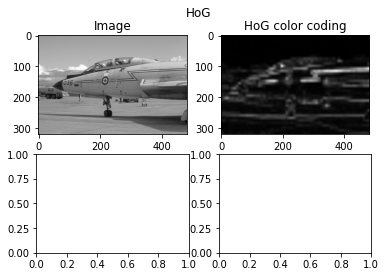

In [ ]:
# Set parameters
block_size = 2      # Cells per block
cell_size = 8       # Pixels per cell
orientations = 9    # Orientations per 180 degrees

img = get_image('canny1.jpg')
normalized_blocks, image_cell_hog  = hog_2D(img, block_size, cell_size, orientations)

# For color coding, take the HoG values per cell, find maximum HoG value among all orientations.
# Then normalize the max value and resize it to match image.
hog_max = np.amax(image_cell_hog, axis=2) #Get max of image_cell_hog using numpy (only do it along last axis which has orientation).
hog_max = hog_max/np.max(hog_max)
hog_max = cv2.resize(hog_max, (img.shape[1],img.shape[0]), cv2.INTER_NEAREST)

# Now draw all the images/outputs using matplotlib.
# Notice that the color is mapped to gray using cmap argument.
# For final submission, remove scikit hog output. You can keep it blank.
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.suptitle('HoG')
ax1.set_title('Image')
ax1.imshow(img, cmap='gray')
ax2.set_title("HoG color coding")
ax2.imshow(hog_max, cmap='gray')
plt.show()

# 2nd iteration of Histogram of Oriented Gradients

This is the 2nd assignment for CAP 4453 and we will implement the Histogram of Oriented gradients algorithm

**Task Overview:**
- Implement the code for computing HoG features using the following parameters
  - 18 bins
  - Cell size: 16x16 pixels
  - Block size: 4x4 cells
- Visualize the computed HoG features

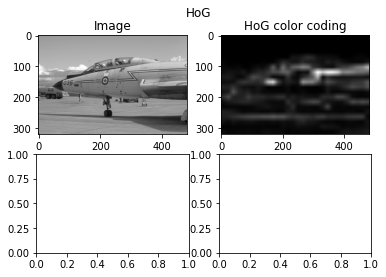

In [ ]:
# Set parameters
block_size = 4       # Cells per block
cell_size = 16       # Pixels per cell
orientations = 18    # Orientations per 180 degrees

img = get_image('canny1.jpg')
normalized_blocks, image_cell_hog  = hog_2D(img, block_size, cell_size, orientations)

# For color coding, take the HoG values per cell, find maximum HoG value among all orientations.
# Then normalize the max value and resize it to match image.
hog_max = np.amax(image_cell_hog, axis=2) #Get max of image_cell_hog using numpy (only do it along last axis which has orientation).
hog_max = hog_max/np.max(hog_max)
hog_max = cv2.resize(hog_max, (img.shape[1],img.shape[0]), cv2.INTER_NEAREST)

# Now draw all the images/outputs using matplotlib.
# Notice that the color is mapped to gray using cmap argument.
# For final submission, remove scikit hog output. You can keep it blank.
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.suptitle('HoG')
ax1.set_title('Image')
ax1.imshow(img, cmap='gray')
ax2.set_title("HoG color coding")
ax2.imshow(hog_max, cmap='gray')
plt.show()